In [ ]:
!unzip CIFAR10.zip

# Imports

In [285]:
from scipy import misc
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, TensorBoard
from tensorflow.keras.initializers import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.regularizers import *

# Load Data

In [3]:
ntrain = 1000 # per class
ntest = 100 # per class
nclass =  10 # number of classes
imsize = 28
nchannels = 1

Train = np.zeros((ntrain*nclass,imsize,imsize,nchannels))
Test = np.zeros((ntest*nclass,imsize,imsize,nchannels))
LTrain = np.zeros((ntrain*nclass,nclass))
LTest = np.zeros((ntest*nclass,nclass))

itrain = -1
itest = -1
for iclass in tqdm(range(0, nclass)):
    for isample in range(0, ntrain):
        path = 'CIFAR10/Train/%d/Image%05d.png' % (iclass,isample)
        im = plt.imread(path); # 28 by 28
        im = im.astype(float)#/255
        itrain += 1
        Train[itrain,:,:,0] = im
        LTrain[itrain,iclass] = 1 # 1-hot label
    for isample in range(0, ntest):
        path = 'CIFAR10/Test/%d/Image%05d.png' % (iclass,isample)
        im = plt.imread(path); # 28 by 28
        im = im.astype(float)#/255
        itest += 1
        Test[itest,:,:,0] = im
        LTest[itest,iclass] = 1 # 1-hot label
        
        
        
tf.random.set_seed(0)
indices = tf.random.shuffle(range(len(Train)), seed=0)
Train = Train[indices]
LTrain = LTrain[indices]

100%|██████████| 10/10 [00:01<00:00,  5.62it/s]


# Model

In [227]:
np.random.seed(0)
tf.random.set_seed(0)

## Hyperparameters

#initializer = tf.initializers.GlorotUniform() # Glorot = Xavier
#actFun = lambda x : tf.nn.leaky_relu(x, alpha=0.2)
weight_init = GlorotNormal()
#weight_init = TruncatedNormal(stddev=0.1, seed=0)
bias_init = Constant(value=0.1)
actFun = Activation(tf.nn.relu)

lr = 1e-3 #1e-4
#boundaries = np.array([16, 20]) 
#values = lr * np.array([1, 0.1, 0.01])
#learning_rate_fn = PiecewiseConstantDecay(list(boundaries), list(values))

#optimizer = Adam(learning_rate=learning_rate_fn) 
#optimizer = SGD(learning_rate=learning_rate_fn)
#optimizer = Adagrad()
optimizer = Nadam(learning_rate=lr*1/6) #1/4
dropout = 0.8
epochs = 25 #5 # 5.5k iterations of 50-image batches from a 55k image dataset = 5 epochs through the whole dataset
batchsize = 50 #20

In [228]:
model_input = Input(shape=(28,28, 1), name='0__original_img')

x = Conv2D(filters=32, kernel_size=(5,5), padding='same', activation=actFun, kernel_regularizer=L2(0.01),
           kernel_initializer=weight_init, bias_initializer=bias_init, name='1__conv1')(model_input) # use_bias=True by default
x = BatchNormalization()(x)
x = MaxPooling2D(padding='same', name='2__pool1')(x) # default strides = default pool size = (2,2)


x = Conv2D(filters=64, kernel_size=(5,5), padding='same', activation=actFun, kernel_regularizer=L2(0.01),
           kernel_initializer=weight_init, bias_initializer=bias_init, name='3__conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(padding='same', name='4__pool2')(x)


x = Reshape([-1, 7*7*64], name='5__reshape')(x)
x = Dense(1024, activation=actFun, kernel_regularizer=L2(0.005), #kernel_regularizer=L1L2(0.001, 0.005),
          kernel_initializer=weight_init, bias_initializer=bias_init, name='6__dense1')(x)
x = Dropout(rate=dropout, seed=0, name='7__dropout')(x)


x = Dense(10, activation='softmax',
          kernel_initializer=weight_init, bias_initializer=bias_init, name='8__dense2')(x)

model_output = x

model = keras.Model(model_input, model_output, name='model')
#model.summary()

In [229]:
np.random.seed(0)
tf.random.set_seed(0)

model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy']
)

In [230]:
np.random.seed(0)
tf.random.set_seed(0)

history = model.fit(Train, tf.reshape(LTrain, (-1, 1, 10)), batch_size=batchsize, epochs=epochs, validation_split=0.1, shuffle=False)

# TODO: figure out how to get more than 50% validation accuracy around epoch 4/5

Epoch 1/25
180/180 [==============================] - 3s 10ms/step - loss: 10.4944 - accuracy: 0.2093 - val_loss: 9.9381 - val_accuracy: 0.1830
Epoch 2/25
180/180 [==============================] - 2s 9ms/step - loss: 8.9990 - accuracy: 0.2940 - val_loss: 8.8501 - val_accuracy: 0.2870
Epoch 3/25
180/180 [==============================] - 2s 9ms/step - loss: 7.9961 - accuracy: 0.3244 - val_loss: 7.4413 - val_accuracy: 0.3960
Epoch 4/25
180/180 [==============================] - 2s 9ms/step - loss: 7.0818 - accuracy: 0.3573 - val_loss: 6.4681 - val_accuracy: 0.4700
Epoch 5/25
180/180 [==============================] - 2s 9ms/step - loss: 6.2617 - accuracy: 0.3904 - val_loss: 5.7871 - val_accuracy: 0.4660
Epoch 6/25
180/180 [==============================] - 2s 9ms/step - loss: 5.5630 - accuracy: 0.4073 - val_loss: 5.1083 - val_accuracy: 0.5040
Epoch 7/25
180/180 [==============================] - 2s 9ms/step - loss: 4.9545 - accuracy: 0.4352 - val_loss: 4.5680 - val_accuracy: 0.5150
Epoc

In [253]:
test_accuracy = (model(Test)[:,0].numpy().argmax(1) == LTest.argmax(1)).sum() / len(Test)
print(f'Test accuracy: {test_accuracy}')

Test accuracy: 0.611


# Statistics and Plotting

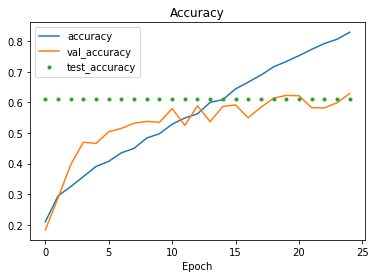

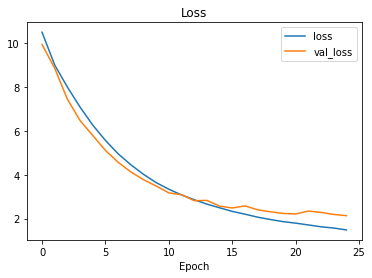

In [261]:
plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot([test_accuracy] * len(history.history['accuracy']), '.', label='test_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

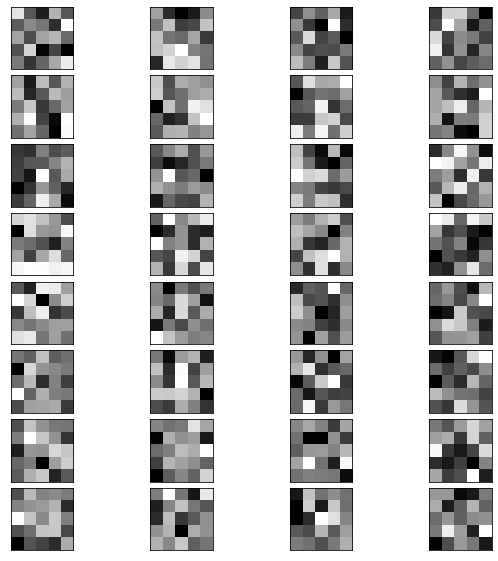

In [292]:
# Plot the first convolutional layer's weights

fig, axs = plt.subplots(8, 4, figsize=(10,10))

for i in range(8):
  for j in range(4):
    filter = model.layers[1].weights[0][:,:,0, i*4 + j].numpy()
    fmin = filter.min()
    fmax= filter.max()
    img = (filter - fmin) / (fmax - fmin)

    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].imshow(img, cmap='gray')

plt.subplots_adjust(wspace=0, hspace=0.1)

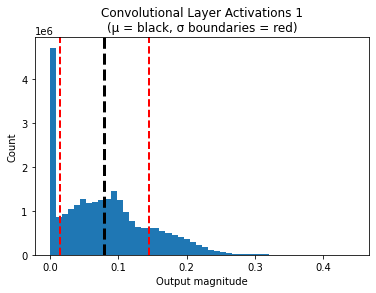

In [333]:
# Plot the activation statistics of the convolutional layers on test images

intermediate1 = keras.Model(model.input, model.get_layer(model.layers[1].name).output)

output1 = intermediate1(Test).numpy()

plt.figure()
plt.hist(output1.flatten(), bins=50)
plt.xlabel('Output magnitude')
plt.ylabel('Count')
plt.title('Convolutional Layer Activations 1\n(μ = black, σ boundaries = red)')
plt.axvline(output1.mean(), color='k', linestyle='dashed', linewidth=3)
plt.axvline(output1.mean() - output1.var()**0.5, color='r', linestyle='dashed', linewidth=2)
plt.axvline(output1.mean() + output1.var()**0.5, color='r', linestyle='dashed', linewidth=2)

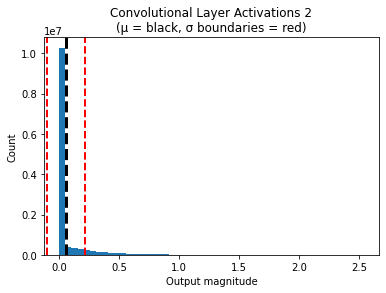

In [334]:
# Plot the activation statistics of the convolutional layers on test images

intermediate2 = keras.Model(model.input, model.get_layer(model.layers[4].name).output)

output2 = intermediate2(Test).numpy()

plt.figure()
plt.hist(output2.flatten(), bins=50)
plt.xlabel('Output magnitude')
plt.ylabel('Count')
plt.title('Convolutional Layer Activations 2\n(μ = black, σ boundaries = red)')
plt.axvline(output2.mean(), color='k', linestyle='dashed', linewidth=3)
plt.axvline(output2.mean() - output2.var()**0.5, color='r', linestyle='dashed', linewidth=2)
plt.axvline(output2.mean() + output2.var()**0.5, color='r', linestyle='dashed', linewidth=2)

# Saving and Loading Model

In [235]:
model.save('sixtyone_percent_validation')

INFO:tensorflow:Assets written to: sixtyone_percent_validation/assets


INFO:tensorflow:Assets written to: sixtyone_percent_validation/assets


In [240]:
temp = tf.keras.models.load_model('sixtyone_percent_validation')

In [244]:
!zip -r sixtyone_percent_validation.zip sixtyone_percent_validation

  adding: sixtyone_percent_validation/ (stored 0%)
  adding: sixtyone_percent_validation/keras_metadata.pb (deflated 91%)
  adding: sixtyone_percent_validation/saved_model.pb (deflated 89%)
  adding: sixtyone_percent_validation/assets/ (stored 0%)
  adding: sixtyone_percent_validation/variables/ (stored 0%)
  adding: sixtyone_percent_validation/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: sixtyone_percent_validation/variables/variables.index (deflated 67%)
